In [16]:
#MATLABで作ったmatファイルを、matフォルダから読み取る
#matファイルは、変数がいくつか保存してあり、それぞれの中身を確認する
#matファイルの中身は、辞書型で保存されている
#辞書型の中身を確認するには、matlab.engineを使う
#matlab.engineを使うには、matlab.engineをインポートする必要がある

# !pip install tensorflow===2.11.0
# import tensorflow as tf

In [17]:
# from tensorflow.python.keras.client import device_lib
# 
# print(device_lib.list_local_devices())


In [18]:
#GPUを用いて、tensorflowを使ったseq2seq回帰LSTMモデルを作成する
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import scipy.io


In [19]:

#データの読み込み
mat_file = 'mat/test_gen_bpsk.mat'
data = scipy.io.loadmat(mat_file)

#matファイルの中身の変数名を確認する

data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Num_tx', 'R_xx', 'R_xx_after_Noise', 'R_xx_exist_Noise', 'SNR_dB', 'inputVec', 'label', 'noise', 's_t', 'sigmaX2', 'stter_vec', 't', 'x'])

In [20]:
a = data['R_xx']
# a = data['R_xx_exist_Noise']
b = data['inputVec']
c = data['label']

# d=data['sigmaX2']
# e=data['t']
#matに保存した変数の呼び出し
#a,b,cの次元数を確認する
print(a.shape)
print(b.shape)
print(c.shape)

#共分散行列
R=a
# #入力信号の電力
# sigmax2=d
# #スナップショット数
# t=e

#実数部と虚数部(虚数単位jは外す)に分ける関数
def split_complex(x):
    real = np.real(x)
    imag = np.imag(x)
    return real, imag

#実数部と虚数部に分ける
real, imag = split_complex(R)


#実数部と虚数部の次元数を確認する
print(real.shape)
print(imag.shape)

#実数部と虚数部を結合し、四次元配列に変換する
R = np.stack([real, imag], axis=3)

#Rの次元数を確認する
print(R.shape)

#Rはx(t)=As(t)+n(t)という信号モデルの共分散行列(Rはx(t)の複素共役転置の期待値)である（Aは方向行列、s(t)は入力信号、n(t)はガウス雑音）
#Rには、本来Aとs(t)とn(t)の情報が含まれているが、今回はn(t)を含まない
#Rにn(t)を乗せる処理を書く
#SNRを定義する
SNR=np.empty((1,1))
np.append(SNR,30)

#送信電力とSNRから雑音電力を求める
#送信電力は、sigmaX2である
#雑音電力は、sigmaN2である
# def calculate_noise_covariance(sigmaX2, SNR, t, R):
#     # 送信電力から雑音電力を計算する
#     # sigman2 = np.divide(sigmaX2, (10**(SNR/10)))
#     #
#     # # sigmaN2を表示する
#     # print(sigman2)
#     #
#     # # ガウス分布に従う雑音n(t)を生成する
#     # noise = np.sqrt(sigman2/2) * (np.random.randn(len(t),len(R[:,0,0,0])) + 1j*np.random.randn(len(t),len(R[:,0,0,0])))
#     #
#     # # n(t)の次元数を確認する
#     # print(noise.shape)
#
#     # # n(t)の共分散行列を求める
#     # N = np.dot(np.conj(noise).T, noise)
#     # N = N / len(t)
#     #
#     # # Nの次元数を確認する
#     # print("R_n", N.shape)
#
#     # Nの実部と虚部を分割する
#     real, imag = np.real(N), np.imag(N)
#
#     # Nを結合して次元数を確認する
#     N = np.stack([real, imag], axis=2)
#     print("R_n", N.shape)
#
#     return N




(10, 10, 1000)
(1000, 101)
(1000, 1)
(10, 10, 1000)
(10, 10, 1000)
(10, 10, 1000, 2)


array([ 0., 30.])

In [21]:
#Rの上三角部分を抽出する
#Rの上三角部分を抽出する関数を定義する

inputValues = np.zeros((1, (R.shape[0]**2) - R.shape[0]))
inputVec = np.zeros((R.shape[2],  R.shape[0]+inputValues.shape[1]+SNR.shape[1], SNR.shape[1]))

tmp_inputVec = np.zeros((R.shape[2], R.shape[0]+inputValues.shape[1]+SNR.shape[1]))

for j in range(len(SNR)):

    # 繰り返し回数と結果を格納するリストの定義
    num_iterations = R.shape[2]
    N = []

    # 繰り返し処理
    # for _ in range(num_iterations):
    #     # 関数の呼び出しと結果の取得
    #     result = calculate_noise_covariance(sigmax2, SNR, t, R)
    #     N.append(result)
    #
    # N=np.array(N)
    # 結果の出力
    # for i, result in enumerate(results):
    #     print(f"Result {i+1}:\n{result}\n")


    #Nの次元数を確認する
    # print("R", R.shape)
    # print("N", N.shape)

    #Nの0番目と2番目の次元数を入れ替える
    # N = np.swapaxes(N, 0, 2)
    # print(N.shape)
    #
    #
    # #RにNを足す
    # R = R + N
    print('R.shape',R.shape)

    for i in range((R.shape[2])):
        real_part=np.empty(1)
        imag_part=np.empty(1)
        # print(np.real(R[1][:]))
        diag_values = np.diag(R[:,:,i,0])
        np.append(real_part,np.real(R[1,:,i,0]))
        np.append(imag_part,np.imag(R[1,:,i,0]))


        for l in range(2, R.shape[0]):
            # print(np.real(R[l][1:l-1]))

            np.append(real_part,np.real(R[l,1:l-1,i,0]))
            np.append(imag_part,np.imag(R[l,1:l-1,i,0]))

        # print(real_part)
        # print(imag_part)

        inputValues = np.zeros(((R.shape[0]**2) - R.shape[0], 1))
        inputValues[:, 0::2] = real_part.reshape(-1, 1)
        inputValues[:, 1::2] = imag_part.reshape(-1, 1)

        print(inputValues.shape)

        diag_values = np.reshape(diag_values, (-1))
        inputValues = np.reshape(inputValues, (-1))
        SNR = np.reshape(np.array(SNR[j]),-1)

        print(inputValues.shape)
        print(diag_values.shape)
        print(SNR.shape)

        # tmp_diag_values = np.reshape(diag_values, (-1, 1))
        # tmp_inputValues = np.reshape(inputValues.flatten(), (-1, 1))
        # tmp_SNR = np.array([[SNR[0, j]]])

        print((np.concatenate([diag_values, inputValues, SNR], axis=0)).reshape(1, -1).shape)
        print(tmp_inputVec.shape)

        tmp_inputVec[i, :] = (np.concatenate([diag_values, inputValues, SNR], axis=0)).reshape(1, -1)

        print(tmp_inputVec[i, :].shape)

    tmp_label = c[:, 0]
    inputVec[:, :, j] = tmp_inputVec
    c[:, j] = tmp_label

    print(inputVec.shape)

R.shape (10, 10, 1000, 2)
(90, 1)
(90,)
(10,)
(1,)
(1, 101)
(1000, 101)
(101,)
(90, 1)
(90,)
(10,)
(1,)
(1, 101)
(1000, 101)
(101,)
(90, 1)
(90,)
(10,)
(1,)
(1, 101)
(1000, 101)
(101,)
(90, 1)
(90,)
(10,)
(1,)
(1, 101)
(1000, 101)
(101,)
(90, 1)
(90,)
(10,)
(1,)
(1, 101)
(1000, 101)
(101,)
(90, 1)
(90,)
(10,)
(1,)
(1, 101)
(1000, 101)
(101,)
(90, 1)
(90,)
(10,)
(1,)
(1, 101)
(1000, 101)
(101,)
(90, 1)
(90,)
(10,)
(1,)
(1, 101)
(1000, 101)
(101,)
(90, 1)
(90,)
(10,)
(1,)
(1, 101)
(1000, 101)
(101,)
(90, 1)
(90,)
(10,)
(1,)
(1, 101)
(1000, 101)
(101,)
(90, 1)
(90,)
(10,)
(1,)
(1, 101)
(1000, 101)
(101,)
(90, 1)
(90,)
(10,)
(1,)
(1, 101)
(1000, 101)
(101,)
(90, 1)
(90,)
(10,)
(1,)
(1, 101)
(1000, 101)
(101,)
(90, 1)
(90,)
(10,)
(1,)
(1, 101)
(1000, 101)
(101,)
(90, 1)
(90,)
(10,)
(1,)
(1, 101)
(1000, 101)
(101,)
(90, 1)
(90,)
(10,)
(1,)
(1, 101)
(1000, 101)
(101,)
(90, 1)
(90,)
(10,)
(1,)
(1, 101)
(1000, 101)
(101,)
(90, 1)
(90,)
(10,)
(1,)
(1, 101)
(1000, 101)
(101,)
(90, 1)
(90,)
(10,)


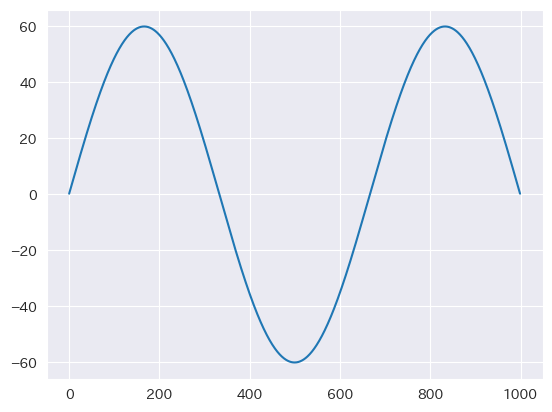

In [22]:
#tensorflowを使ったseq2seq回帰LSTMモデルを作成する

#matファイルで読み込んだinputVecとlabelからデータセットを作成する
#データセットは、inputVecとlabelの組み合わせで、入力と出力を作成する
X = inputVec
Y = c

#Yをプロットする
plt.plot(Y)
plt.show()


In [23]:
#データセットを標準化する
#標準化すると、平均が0、標準偏差が1になる

from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(X)
# X = scaler.transform(X)

for i in range(X.shape[0]):
    # シートごとのデータを抽出
    sheet_data = X[i]

    # 標準化器を作成し、データを標準化
    scaler = StandardScaler()
    sheet_data_standardized = scaler.fit_transform(sheet_data)

    # 標準化されたデータを元の配列に戻す
    X[i] = sheet_data_standardized



In [24]:
#データセットの特徴量の値の大部分が同じデータのみの場合にその行（もしくは列）を削除する

from sklearn.feature_selection import VarianceThreshold

for i in range(X.shape[0]):
    sheet_data = X[i]  # シートごとのデータを抽出

    # VarianceThresholdを適用して行（もしくは列）を削除
    selector = VarianceThreshold()
    sheet_data_selected = selector.fit_transform(sheet_data)

    # 削除後のデータを元の配列に戻す
    if sheet_data_selected.ndim == 1:
        sheet_data_selected = sheet_data_selected.reshape(-1, 1)
    X[i] = sheet_data_selected


In [25]:
#Xを3次元配列に変換する
X = np.reshape(X, (X.shape[0], X.shape[1], 1))



In [26]:
from sklearn.model_selection import train_test_split

#学習データセットと検証データセットとテストデータセットの分割割合を変数で指定する
train_size = 0.8
val_size = 0.1
test_size = 0.1

#学習データセットと検証データセットとテストデータセットを分割する(シャッフルはしない)
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=1 - train_size, shuffle=False)
XVal, XTest, YVal, YTest = train_test_split(XTest, YTest, test_size=test_size / (test_size + val_size), shuffle=False)

#学習データセットと検証データセットとテストデータセットの次元数を確認する
print(XTrain.shape)
print(XVal.shape)
print(XTest.shape)
print(YTrain.shape)
print(YVal.shape)
print(YTest.shape)

#入力の次元はそれぞれ(サンプル数、タイムステップ数、特徴量)である
#Xの2番目の次元と3番目の次元を入れ替える
XTrain = np.swapaxes(XTrain, 1, 2)
XVal = np.swapaxes(XVal, 1, 2)
XTest = np.swapaxes(XTest, 1, 2)


(800, 101, 1)
(100, 101, 1)
(100, 101, 1)
(800, 1)
(100, 1)
(100, 1)


In [27]:
#GPUを使ったLSTMmodelの作成

#tensorflowのバージョンを確認する
print(tf.__version__)


2.11.0


In [28]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# from keras.layers.normalization import batch_normalization
# from tensorflow.python.keras.layers import
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers

#モデルの層の作成(cudNNLSTM層を使用するためのインポート)
# from tensorflow.keras.layers import CuDNNLSTM


print((XTrain.shape[1:]))

hidden_units = 256

#モデルの作成
model = Sequential()
# model.add(layers.CuDNNGRU(hidden_units, input_shape=(XTrain.shape[1:]), return_sequences=True))
model.add(layers.LSTM(hidden_units, input_shape=(XTrain.shape[1:]), return_sequences=True))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))


model.add(layers.LSTM(hidden_units, return_sequences=True))
model.add(layers.LSTM(hidden_units, return_sequences=True))

# model.add(layers.CuDNNGRU(hidden_units, return_sequences=True))
# model.add(layers.CuDNNGRU(hidden_units, return_sequences=True))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

# model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='relu'))

# LearningRateSchedulerコールバックを作成する
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

opt = Adam(learning_rate=0.01)

# コンパイル時にオプティマイザを指定する(損失関数はMSE、評価関数はRMSEをカスタムで実装)

loss_func = tf.keras.losses.MeanSquaredError(
    reduction='auto', name='mean_squared_error'
)

eval_func = tf.keras.metrics.RootMeanSquaredError(
    name='root_mean_squared_error', dtype=None
)

model.compile(loss=loss_func, optimizer=opt, metrics=eval_func)

#モデルの概要を表示する
model.summary()


(1, 101)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 256)            366592    
                                                                 
 lstm_4 (LSTM)               (None, 1, 256)            525312    
                                                                 
 lstm_5 (LSTM)               (None, 1, 256)            525312    
                                                                 
 dropout_1 (Dropout)         (None, 1, 256)            0         
                                                                 
 dense_1 (Dense)             (None, 1, 2)              514       
                                                                 
Total params: 1,417,730
Trainable params: 1,417,730
Non-trainable params: 0
_________________________________________________________________


In [29]:
# TensorBoardコールバックを作成
tensorboard = TensorBoard(log_dir='./logs')
#plotをlocalhostで表示

#ターミナルにコマンドを打つ
# tensorboard --logdir logs


In [30]:

#モデルの学習

#モデルの学習の早期終了の設定
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
max_epochs = 1000
mini_batch_size = 64

#モデルの学習
history = model.fit(XTrain, YTrain, batch_size=mini_batch_size, epochs=max_epochs, validation_data=(XVal, YVal),callbacks=[reduce_lr, tensorboard])


Epoch 1/1000


2023-12-18 19:16:12.863256: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2023-12-18 19:16:12.863386: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-12-18 19:16:12.873608: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2023-12-18 19:16:12.873725: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc


InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_10' defined at (most recent call last):
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_3878/462095909.py", line 9, in <module>
      history = model.fit(XTrain, YTrain, batch_size=mini_batch_size, epochs=max_epochs, validation_data=(XVal, YVal),callbacks=[reduce_lr, tensorboard])
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/b2190180/anaconda3/envs/DOAest/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_10'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_10}}]] [Op:__inference_train_function_17139]

In [ ]:
#モデルの評価

#モデルの評価
score = model.evaluate(XTest, YTest, verbose=1)

#モデルの評価結果を表示する
print('Test loss:', score[0])
print('Test accuracy:', score[1])


In [ ]:
#モデルの保存

#モデルの保存
model.save('model/LSTMmodel.h5')


In [ ]:
#モデルの読み込み

#モデルの読み込み
model = tf.keras.models.load_model('model/LSTMmodel.h5')

#モデルの概要を表示する
model.summary()

In [ ]:
#モデルの評価

#モデルの評価
score = model.evaluate(XTest, YTest, verbose=1)

#モデルの評価結果を表示する
print('Test loss:', score[0])
print('Test accuracy:', score[1])



In [ ]:
#モデルの予測

#モデルの予測

#予測値を格納する変数を作成する
YTestPred = np.zeros((YTest.shape[0], 1))

#予測値を計算する
YTestPred = model.predict(XTest)

#予測値を表示する
print(YTestPred[:, 0, :])


In [ ]:
#予測値と正解値のグラフを表示する
print(YTestPred[:, 0, 0].shape)
print(YTest.shape)

#予測値と正解値を一つのグラフに表示する
plt.plot(YTestPred[:, 0, 0], label='YTestPred', color='red')
plt.plot(YTest[:, 0], label='YTest', linestyle='dashed', color='blue')
plt.ylim(-90, 90)
plt.legend()
plt.show()


In [ ]:
#推定値と正解値との許容誤差が0～10の範囲内での平均二乗誤差の平方根をとった値のグラフを表示する

#推定値と正解値との許容誤差が0～10の範囲内での平均二乗誤差の平方根をとった値を計算する
YTestDiff = ((YTestPred[:, 0, 0] - YTest[:, 0]))

#推定値と正解値との許容誤差が0～10の範囲内での平均二乗誤差の平方根をとった値を表示する
print(YTestDiff.shape)

thr = np.arange(0, 10.5, 0.5)
numCorrect = np.zeros(len(thr))
numValidationImages = np.zeros(len(thr))
accuracy = np.zeros(len(thr))

for i in range(len(thr)):
    numCorrect[i] = np.sum(np.abs(YTestDiff) < thr[i])
    numValidationImages[i] = np.size(YTest[:, 0])
    accuracy[i] = numCorrect[i] / numValidationImages[i]

plt.scatter(thr, accuracy)
plt.xlabel("許容誤差(deg)")
plt.ylabel("accuracy")
plt.grid(True)
plt.plot(thr, accuracy, '.-', markersize=12)
plt.show()

In [ ]:
#予測値と正解値の差分のヒストグラムを表示する

#予測値と正解値の差分のヒストグラムを表示する
plt.hist(YTestDiff, bins=100)
plt.show()


In [ ]:
#予測値と正解値の差分の統計量を表示する

#予測値と正解値の差分の統計量を表示する
print(pd.DataFrame(YTestDiff).describe())


In [ ]:
#